In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

colors = {
    'bg': '#EFE8E8',
    'text': '#513838',
    
    'red': '#DC3545',
    'blue': "#4476C2",
    'cyan': '#0AA2C0',
    'green': '#1AA179',
    'purple': '#7121F3',
    'orange': '#FD7E14',
    'yellow': '#FFC107',
    'pink': '#D63384',
    'white_green': "#64B099"
}

custom_palette = [
    colors['blue'], colors['red'], colors['green'], 
    colors['orange'], colors['purple'], colors['cyan']
]

custom_params = {
    "figure.facecolor": colors['bg'],
    "axes.facecolor": colors['bg'],
    "savefig.facecolor": colors['bg'],
    
    "text.color": colors['text'],
    "axes.labelcolor": colors['text'],
    "xtick.color": colors['text'],
    "ytick.color": colors['text'],
    "font.family": "sans-serif",
    
    "axes.grid": True,
    "grid.color": colors['text'],
    "grid.alpha": 0.15,
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.edgecolor": colors['text'],
    "axes.linewidth": 0.8,
    
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
}

sns.set_theme(
    context="talk",
    style="whitegrid",
    rc=custom_params,
    palette=custom_palette
)

<Figure size 1400x1000 with 0 Axes>

In [20]:
df = pd.read_csv('dfp.csv')
print(df['id_client'].nunique())

49294


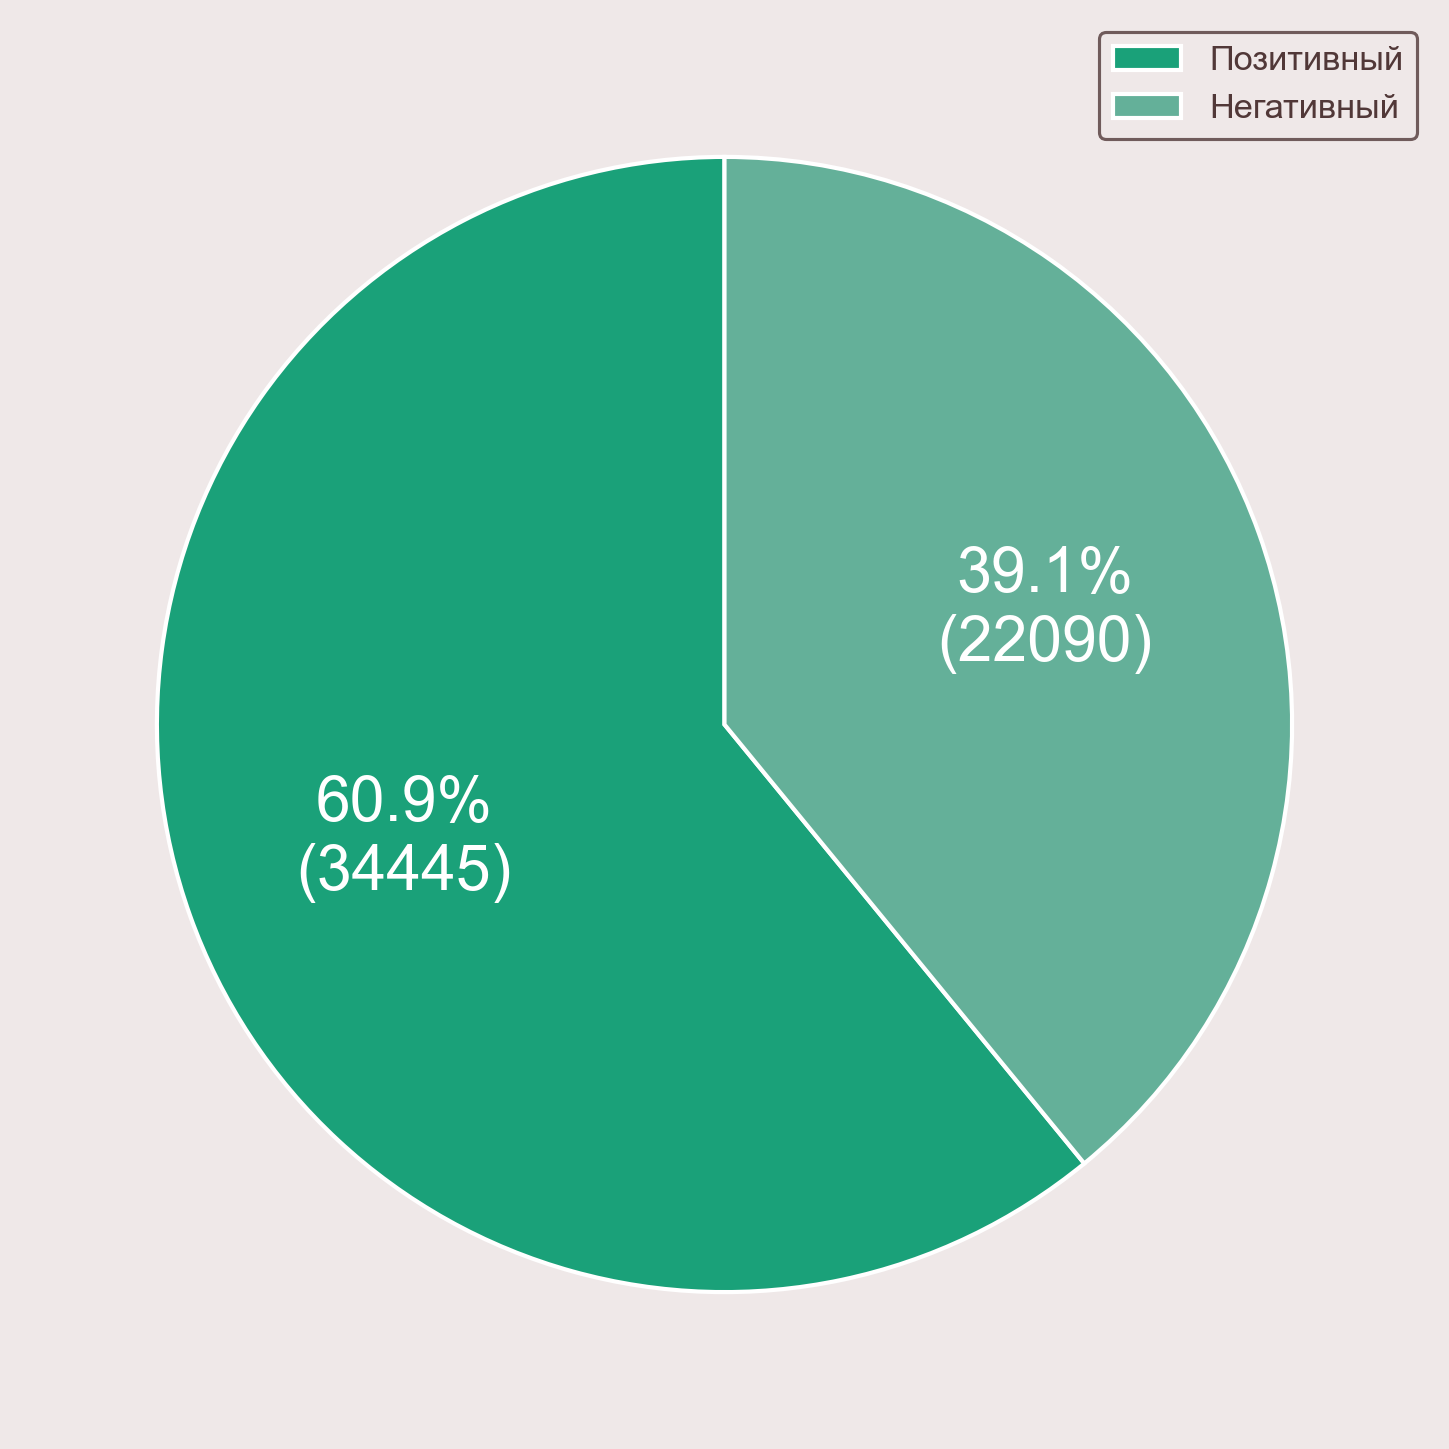

In [21]:
s = df['review_emotion'].copy()

s = s.map({0: "Негативный", 1: "Позитивный"})

counts = s.value_counts()

labels = counts.index.tolist()
sizes  = counts.values

fig, ax = plt.subplots(figsize=(14, 10), dpi=150)

ax.grid(False)

def autopct_func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    if pct > 0:
        return f"{pct:.1f}%\n({absolute})"
    else:
        return ""

wedges, _, autotexts = ax.pie(
    sizes,
    startangle=90,
    colors=[colors["green"], colors["white_green"]],
    autopct=lambda p: autopct_func(p, sizes),
    wedgeprops=dict(edgecolor="white", linewidth=2),
    textprops=dict(color="white", fontsize=30) 
)

ax.legend(
    wedges, labels,
    loc="upper right",
    frameon=True,
    facecolor=colors["bg"],
    edgecolor=colors["text"]
)

ax.set_aspect("equal")
ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

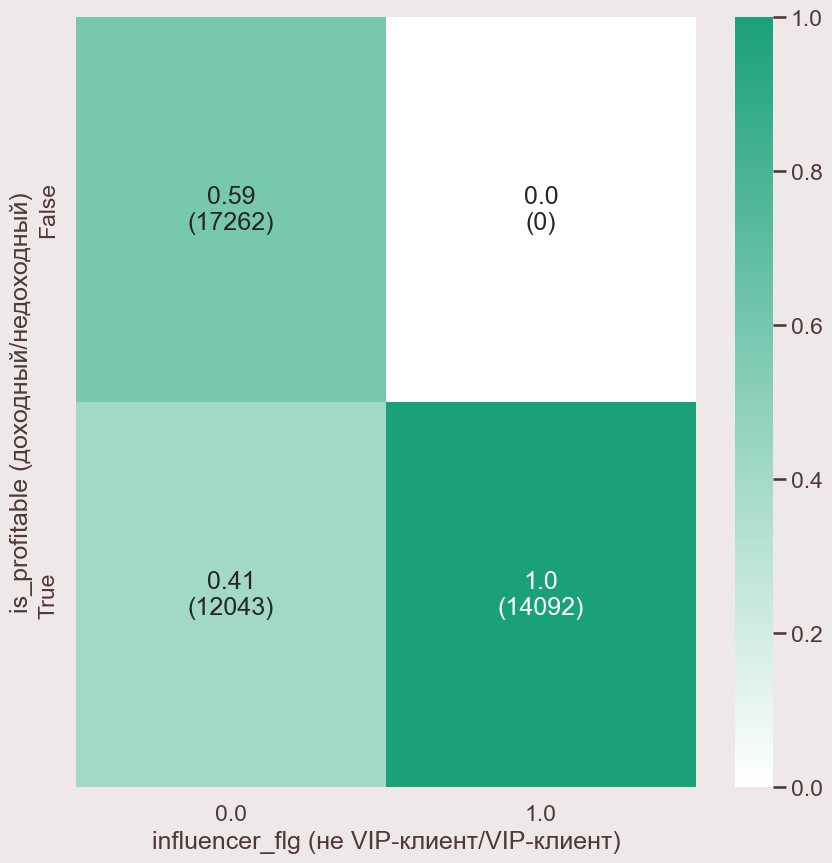

In [22]:
corr_table = pd.crosstab(df['is_profitable'], df['influencer_flg'], normalize='columns')
count_table = pd.crosstab(df['is_profitable'], df['influencer_flg'])

annot = corr_table.round(2).astype(str) + '\n(' + count_table.astype(str) + ')'

from matplotlib.colors import LinearSegmentedColormap

green_grad = LinearSegmentedColormap.from_list("white_to_green", ["#FFFFFF", "#1AA179"])

plt.figure(figsize=(10, 10))
sns.heatmap(corr_table, annot=annot, cmap=green_grad, fmt="", cbar=True)
plt.xlabel("influencer_flg (не VIP-клиент/VIP-клиент)")
plt.ylabel("is_profitable (доходный/недоходный)")
plt.show()


In [23]:
influencer_numeric = df['influencer_flg'].notna().astype(int)
profitable_numeric = df['is_profitable'].astype(int)

corr_coef = influencer_numeric.corr(profitable_numeric)
print(f"Коэффициент корреляции Пирсона между influencer_flg и is_profitable: {corr_coef:.3f}")


Коэффициент корреляции Пирсона между influencer_flg и is_profitable: 0.510


In [24]:
before = len(df)
duplicates_count = df.duplicated().sum()
df = df.dropna(subset=['influencer_flg'])
df = df.drop_duplicates()
df = df[df['review_emotion'] != 1]
after = len(df)
removed = before - after
print(f"Количество строк до очистки: {before}")
print(f"Количество дубликатов: {duplicates_count}")
print(f"Количество строк после очистки: {after}")
print(f"Удалено строк: {removed}")

print(df['id_client'].nunique())

Количество строк до очистки: 56535
Количество дубликатов: 0
Количество строк после очистки: 18791
Удалено строк: 37744
16300


In [25]:
df.to_csv('dfc.csv', index=False)

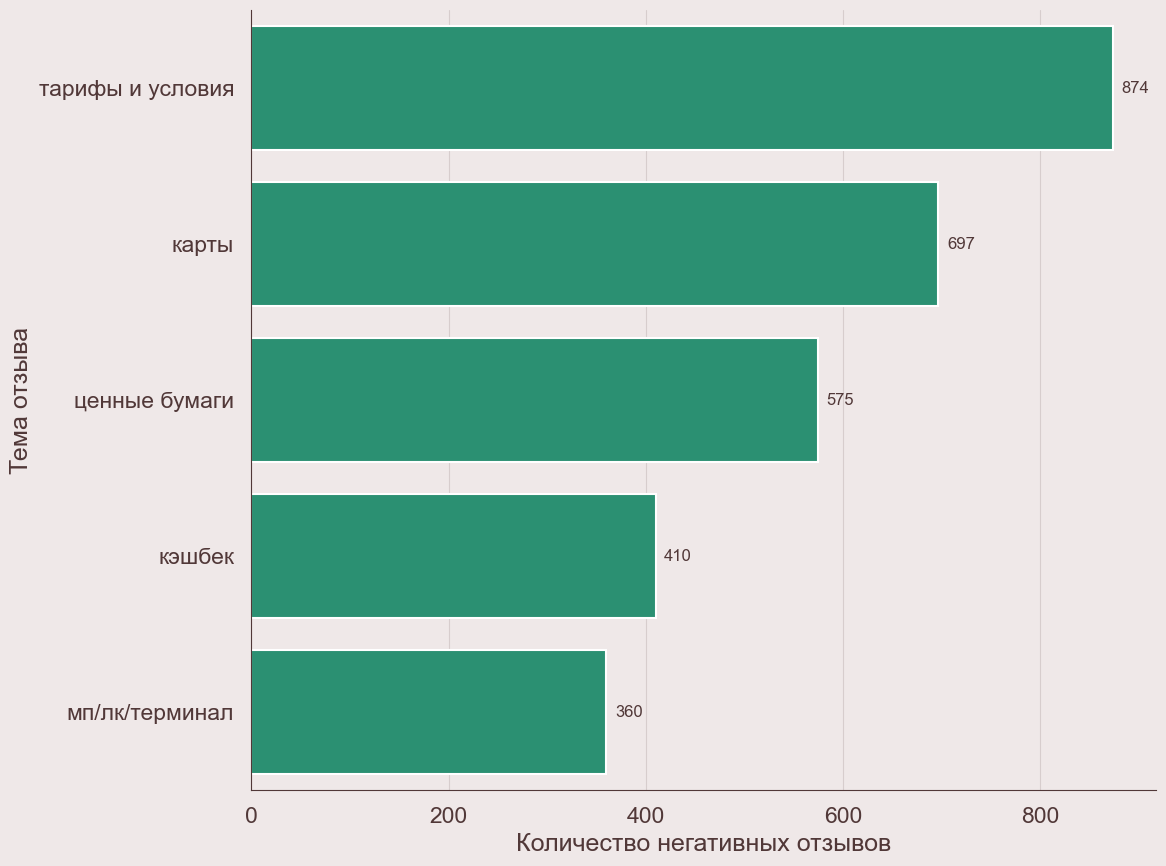

In [26]:
vip_negative = df[(df['influencer_flg'] == 1) & (df['review_emotion'] == 0)]

top_neg_reasons = vip_negative['review_theme'].value_counts().head(5)

plt.figure(figsize=(12, 9))
ax = sns.barplot(
    x=top_neg_reasons.values,
    y=top_neg_reasons.index,
    color=colors['green']
)
plt.xlabel("Количество негативных отзывов")
plt.ylabel("Тема отзыва")

for i, (value, label) in enumerate(zip(top_neg_reasons.values, top_neg_reasons.index)):
    ax.text(value + max(top_neg_reasons.values)*0.01, i, str(value), va='center', ha='left', fontsize=12)

plt.tight_layout()
plt.show()


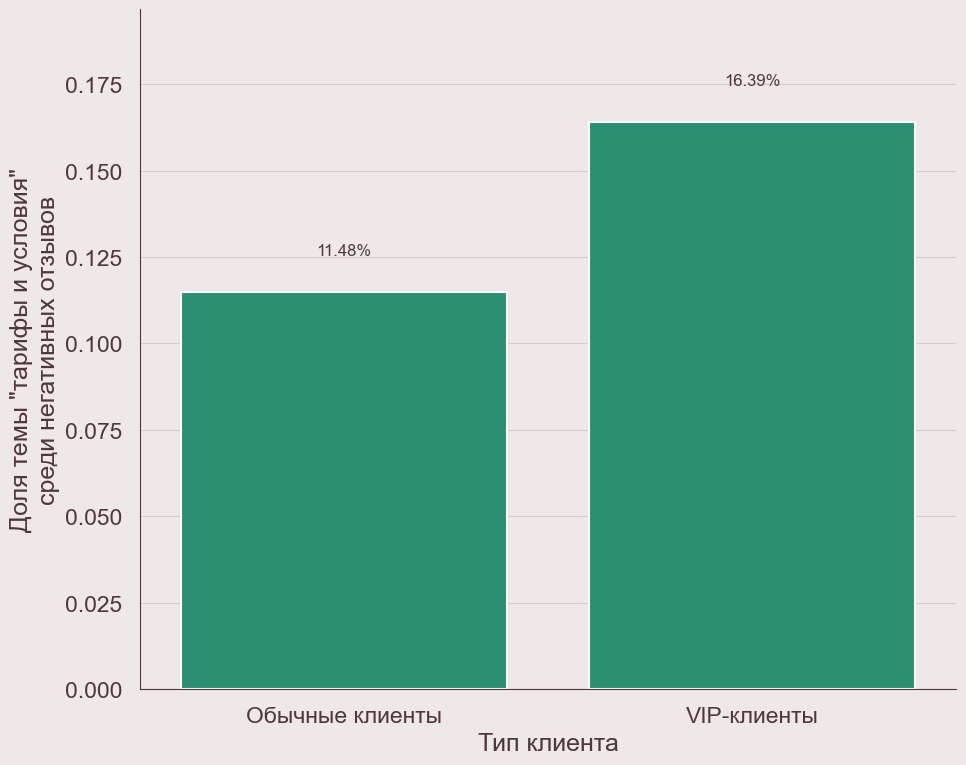

In [27]:
neg_df = df[df['review_emotion'] == 0]

shares = []
labels = ['Обычные клиенты', 'VIP-клиенты']
for f in [0, 1]:
    group = neg_df[neg_df['influencer_flg'] == f]
    total = len(group)
    theme_count = (group['review_theme'] == 'тарифы и условия').sum()
    share = theme_count / total if total > 0 else 0
    shares.append(share)

plt.figure(figsize=(10,8))
ax = sns.barplot(x=labels, y=shares, color=colors['green'])
plt.ylabel('Доля темы "тарифы и условия"\nсреди негативных отзывов')
plt.xlabel('Тип клиента')
for i, v in enumerate(shares):
    ax.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom', fontsize=12)
plt.ylim(0, max(shares) * 1.2)
plt.tight_layout()
plt.show()
